In [ ]:
import pandas as pd
df=pd.read_excel("/content/checking.xlsx")
df

,headlines,sentiment
0,Record Highs for the Stock Market This Quarter,positive
1,Investors Celebrate Strong Earnings Reports,positive
2,Small Businesses See Surge in Revenue,positive
3,Real Estate Prices Rise Amid Economic Growth,positive
4,Consumer Confidence Reaches New Peak,positive
...,...,...
288,Payment Gateway Activity Levels Off,neutral
289,Retail Footfall Remains Comparable to Previous...,neutral
290,Financial Services Sector Sees No Major Changes,neutral
291,Stock Buyback Programs Continue as Planned,neutral


In [ ]:
df.isna().sum()

,0
headlines,0
sentiment,0


In [ ]:
df.sentiment.value_counts()

,count
sentiment,
positive,101
neutral,100
negative,92


In [ ]:
label_mapping = {"neutral": 0, "positive": 1, "negative": 2}
df["label_num"] = df["sentiment"].map(label_mapping)
df

,headlines,sentiment,label_num
0,Record Highs for the Stock Market This Quarter,positive,1
1,Investors Celebrate Strong Earnings Reports,positive,1
2,Small Businesses See Surge in Revenue,positive,1
3,Real Estate Prices Rise Amid Economic Growth,positive,1
4,Consumer Confidence Reaches New Peak,positive,1
...,...,...,...
288,Payment Gateway Activity Levels Off,neutral,0
289,Retail Footfall Remains Comparable to Previous...,neutral,0
290,Financial Services Sector Sees No Major Changes,neutral,0
291,Stock Buyback Programs Continue as Planned,neutral,0


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df

,headlines,sentiment,label_num
0,Mutual Fund Sector Experiences Stable NAV Move...,neutral,0
1,Public Spending Maintains Last Year’s Levels,neutral,0
2,Stock Buybacks Reflect Corporate Optimism,positive,1
3,Consumer Confidence Drops Sharply,negative,2
4,Public Investment Projects Boost Regional Growth,positive,1
...,...,...,...
288,Small Businesses See Surge in Revenue,positive,1
289,Subscription-Based Businesses Report Growth,positive,1
290,Central Bank Releases Cautious Outlook,neutral,0
291,Retail Sales Decline in Key Sectors,negative,2


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
model_name = "kkkkkjjjjjj/results"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


# Custom dataset
class HeadlineDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len=128):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.headlines[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx])
        }

# Create DataLoader
dataset = HeadlineDataset(
    df["headlines"].tolist(),
    df["label_num"].tolist(),
    tokenizer
)
loader = DataLoader(dataset, batch_size=16)

# Predict
preds = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(loader):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        preds.extend(predictions.tolist())
        true_labels.extend(labels.tolist())

# Accuracy
accuracy = accuracy_score(true_labels, preds)
print("Accuracy:", accuracy)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

100%|██████████| 19/19 [01:38<00:00,  5.16s/it]

Accuracy: 0.8191126279863481


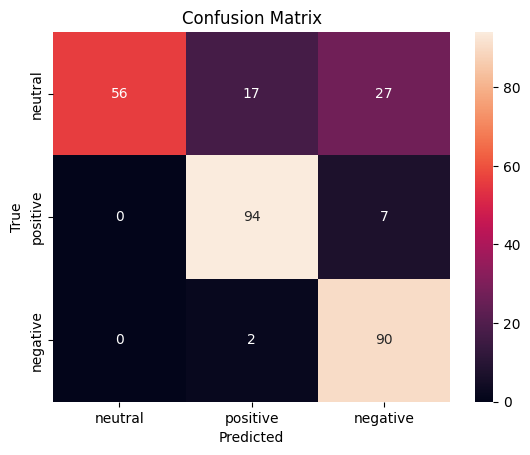

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(true_labels, preds, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

     neutral       1.00      0.56      0.72       100
    positive       0.83      0.93      0.88       101
    negative       0.73      0.98      0.83        92

    accuracy                           0.82       293
   macro avg       0.85      0.82      0.81       293
weighted avg       0.86      0.82      0.81       293

